In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import ecos

In [ ]:
df = pd.read_csv('project_RM.csv')
df['<DATE>'] = pd.to_datetime(df['<DATE>'], format="%d/%m/%y")
df.columns = ['TICKER', 'DATE', 'CLOSE']

In [ ]:
# Преобразование в широкий формат
pivot_df = df.pivot(index='DATE', columns='TICKER', values='CLOSE').sort_index().asfreq('B').ffill()

# Расчет логарифмических доходностей
returns = np.log(pivot_df / pivot_df.shift(1))

In [ ]:
start_date = '2019-12-31'
end_date = '2024-12-31'
df_window = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]

In [ ]:
pivot_data = df_window.pivot(index='DATE', columns='TICKER', values='CLOSE').sort_index(ascending=True)

In [ ]:
expected_returns = returns.mean().values * 252  # Годовая доходность

# Для логарифмических доходностей:
returns = np.log(pivot_df / pivot_df.shift(1)).dropna()
covariance_matrix = returns.cov().values * 252  # Годовая ковариация

## 22. Теорема Блэка

In [ ]:
#returns = pivot_data.pct_change()
#mean_returns = returns.mean().values * 252
#cov_matrix = returns.cov()
num_portfolios = 30
risk_free_rate = 0.1

constrain_set = (-1,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constrain_set)

In [ ]:
import cvxpy as cp
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']


In [ ]:
cov_matrix = returns.cov().values * 252
print(len(returns))
cov_matrix.shape

205


(30, 30)

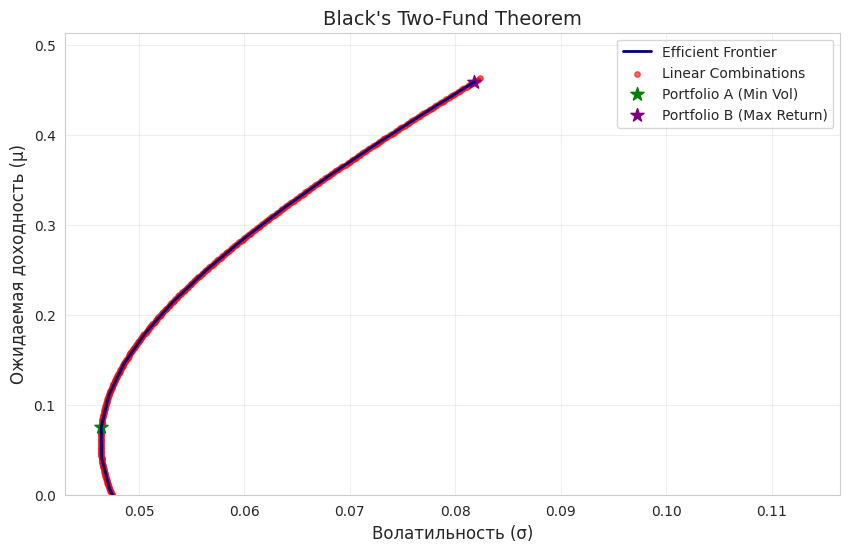

In [259]:
## Расчет ковариационной матрицы и ожидаемых доходностей
returns = np.log(pivot_df / pivot_df.shift(1)).dropna()
cov_matrix = returns.cov().values * 252  # Годовая ковариация
cov_matrix += np.eye(30) * 1e-6  # Регуляризация

expected_returns = returns.mean().values * 252  # Годовые доходности

# Построение эффективной границы
target_returns = np.linspace(
    expected_returns.min(),
    expected_returns.max(),
    100
)
frontier_volatilities = []
frontier_returns = []
frontier_weights = []

for r in target_returns:
    w = cp.Variable(30)
    objective = cp.Minimize(cp.quad_form(w, cov_matrix))
    constraints = [
        w @ expected_returns == r,
        cp.sum(w) == 1
    ]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)

    if problem.status == 'optimal':
        frontier_weights.append(w.value)
        frontier_returns.append(r)
        frontier_volatilities.append(np.sqrt(w.value @ cov_matrix @ w.value))
    else:
        print(f"Ошибка оптимизации для r = {r:.4f}")

# Выбор двух портфелей
min_vol_idx = np.argmin(frontier_volatilities)
w_A = frontier_weights[min_vol_idx]  # Минимальная волатильность

max_return_idx = np.argmax(frontier_returns)
w_B = frontier_weights[max_return_idx]  # Максимальная доходность

# Генерация линейных комбинаций
alphas = np.linspace(-0.01, 2, 500)
combined_returns = []
combined_volatilities = []

for alpha in alphas:
    w = alpha * w_A + (1 - alpha) * w_B
    mu = w @ expected_returns
    sigma = np.sqrt(w @ cov_matrix @ w.T)
    combined_returns.append(mu)
    combined_volatilities.append(sigma)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(frontier_volatilities[70:], target_returns[70:],
         label='Efficient Frontier', lw=2, color='navy')
plt.scatter(combined_volatilities, combined_returns,
            s=15, alpha=0.6, color='red', label='Linear Combinations')
plt.scatter([np.sqrt(w_A @ cov_matrix @ w_A)], [w_A @ expected_returns],
            s=100, color='green', marker='*', label='Portfolio A (Min Vol)')
plt.scatter([np.sqrt(w_B @ cov_matrix @ w_B)], [w_B @ expected_returns],
            s=100, color='purple', marker='*', label='Portfolio B (Max Return)')

plt.title("Black's Two-Fund Theorem", fontsize=14)
plt.xlabel('Волатильность (σ)', fontsize=12)
plt.ylabel('Ожидаемая доходность (μ)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.show()

In [ ]:
len(frontier_volatilities)

100

## 23. Метод Монте-Карло

In [239]:
def generate_weights(n_assets, n_portfolios, allow_short=False):
    weights = np.random.randn(n_portfolios, n_assets) if allow_short else np.random.rand(n_portfolios, n_assets)
    weights /= weights.sum(axis=1)[:, np.newaxis]
    return weights

In [260]:
n_sim = 1000

In [261]:
n_portfolios = 100
weights = generate_weights(n_assets=30, n_portfolios=n_portfolios, allow_short=False)

In [241]:
#Параметры исторических данных
mu_hist = returns.mean().mean()  # Средняя доходность
sigma_hist = returns.std().mean()  # Среднее стандартное отклонение

# Генерация данных методом Монте-Карло (на основе исторических параметров)
portfolio_returns = np.random.normal(loc=mu_hist, scale=sigma_hist, size=n_portfolios)
portfolio_volatilities = np.sqrt(np.diag(weights @ cov_matrix @ weights.T))

In [255]:
# Для доходности
q25_ret, q75_ret = np.percentile(portfolio_returns, [20, 80])
iqr_ret = q75_ret - q25_ret
lower_bound_ret = q25_ret - 1.5 * iqr_ret
upper_bound_ret = q75_ret + 1.5 * iqr_ret

# Для волатильности
q25_vol, q75_vol = np.percentile(portfolio_volatilities, [20, 80])
iqr_vol = q75_vol - q25_vol
lower_bound_vol = q25_vol - 1.5 * iqr_vol
upper_bound_vol = q75_vol + 1.5 * iqr_vol

In [256]:
mask = (
    (portfolio_returns >= lower_bound_ret) &
    (portfolio_returns <= upper_bound_ret) &
    (portfolio_volatilities >= lower_bound_vol) &
    (portfolio_volatilities <= upper_bound_vol)
)

filtered_returns = portfolio_returns[mask]
filtered_volatilities = portfolio_volatilities[mask]
filtered_weights = weights[mask]

In [257]:
# Сортировка и выделение эффективных портфелей
sorted_indices = np.argsort(filtered_volatilities)
sorted_returns = filtered_returns[sorted_indices]
sorted_volatilities = filtered_volatilities[sorted_indices]

efficient_frontier = []
max_return = -np.inf
for vol, ret in zip(sorted_volatilities, sorted_returns):
    if ret > max_return:
        efficient_frontier.append((vol, ret))
        max_return = ret

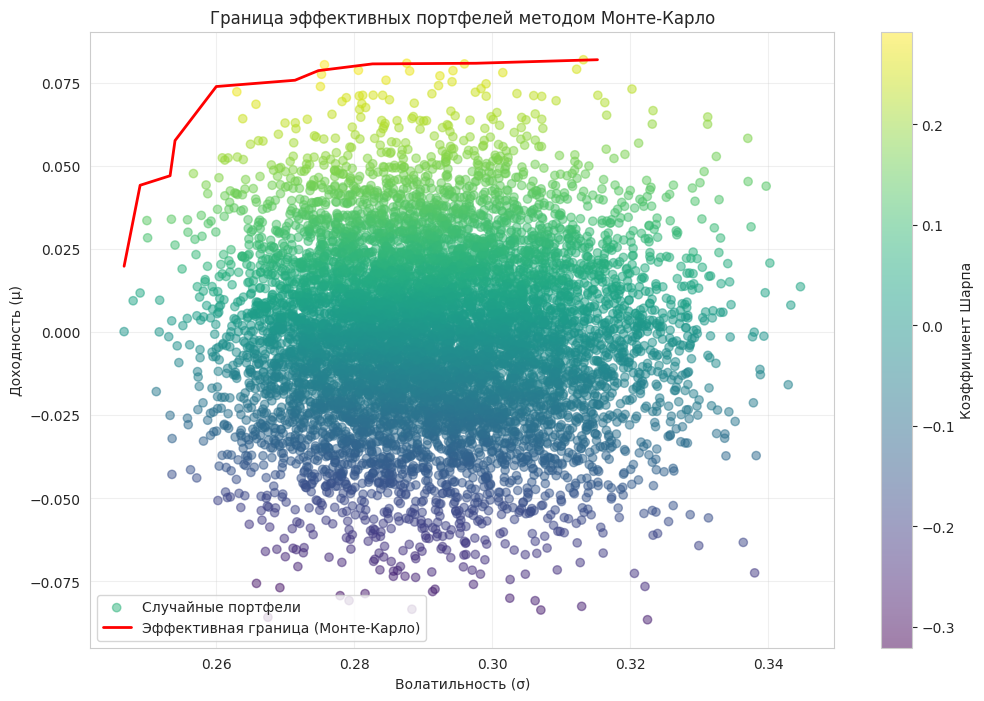

In [258]:
plt.figure(figsize=(12, 8))
plt.scatter(filtered_volatilities, sorted_returns, c=sorted_returns/filtered_volatilities, cmap='viridis', alpha=0.5, label='Случайные портфели')
plt.plot([ef[0] for ef in efficient_frontier], [ef[1] for ef in efficient_frontier], color='red', linewidth=2, label='Эффективная граница (Монте-Карло)')
#plt.plot(frontier_volatilities, target_returns, linestyle='--', color='blue', label='Классическая граница')
plt.title('Граница эффективных портфелей методом Монте-Карло')
plt.xlabel('Волатильность (σ)')
plt.ylabel('Доходность (μ)')
plt.colorbar(label='Коэффициент Шарпа')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


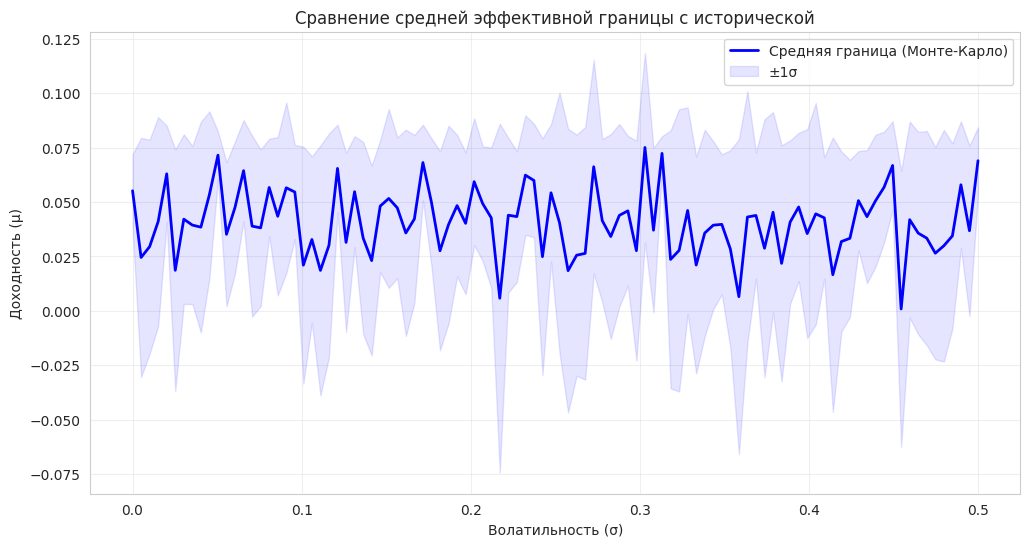

In [268]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # Для визуализации прогресса

# Параметры
n_simulations = 100  # Количество симуляций
n_portfolios_per_sim = 1000  # Портфелей на симуляцию
n_assets = 30  # Количество активов
#Параметры исторических данных
mu_hist = returns.mean().mean()  # Средняя доходность
sigma_hist = returns.std().mean()  # Среднее стандартное отклонение



# Предположим, есть данные: expected_returns, cov_matrix
# (рассчитанные из исторических данных)

# Сетка для интерполяции эффективных границ
vol_grid = np.linspace(0, 0.5, 100)  # Пример: волатильность от 0% до 50%

# Список для хранения всех эффективных границ
all_efficient_curves = []

# 1. Генерация 100 симуляций
for _ in tqdm(range(n_simulations)):
    # Генерация случайных весов (без коротких продаж)
    weights = generate_weights(n_assets=30, n_portfolios=n_portfolios_per_sim, allow_short=False)
    weights /= weights.sum(axis=1)[:, np.newaxis]

    # Расчет доходности и волатильности
    # Генерация данных методом Монте-Карло (на основе исторических параметров)
    portfolio_returns = np.random.normal(loc=mu_hist, scale=sigma_hist, size=n_portfolios_per_sim)
    portfolio_volatilities = np.sqrt(np.diag(weights @ cov_matrix @ weights.T))

    # Построение эффективной границы для текущей симуляции
    sorted_indices = np.argsort(portfolio_volatilities)
    sorted_vol = portfolio_volatilities[sorted_indices]
    sorted_ret = portfolio_returns[sorted_indices]

    efficient_curve = []
    max_ret = -np.inf
    for vol, ret in zip(sorted_vol, sorted_ret):
        if ret > max_ret:
            efficient_curve.append((vol, ret))
            max_ret = ret

    # Интерполяция на общую сетку волатильностей
    if len(efficient_curve) > 1:
        vol_curve = np.array([x[0] for x in efficient_curve])
        ret_curve = np.array([x[1] for x in efficient_curve])
        interp_ret = np.interp(vol_grid, vol_curve, ret_curve)
        all_efficient_curves.append(interp_ret)

# 2. Расчет средней кривой
mean_curve = np.nanmean(all_efficient_curves, axis=1)
std_curve = np.nanstd(all_efficient_curves, axis=1)

# 3. Загрузка предыдущей эффективной границы (пример)
# prev_vol = [ваши данные]
# prev_ret = [ваши данные]

# 4. Визуализация
plt.figure(figsize=(12, 6))
plt.plot(vol_grid, mean_curve, color='blue', lw=2, label='Средняя граница (Монте-Карло)')
plt.fill_between(vol_grid, mean_curve - std_curve, mean_curve + std_curve,
                 color='blue', alpha=0.1, label='±1σ')

# Если есть предыдущая граница:
#plt.plot(frontier_volatilities, target_returns, color='red', linestyle='--', label='Предыдущая граница')

plt.title('Сравнение средней эффективной границы с исторической')
plt.xlabel('Волатильность (σ)')
plt.ylabel('Доходность (μ)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

100%|██████████| 100/100 [00:03<00:00, 31.69it/s]


ValueError: 'y1' is not 1-dimensional

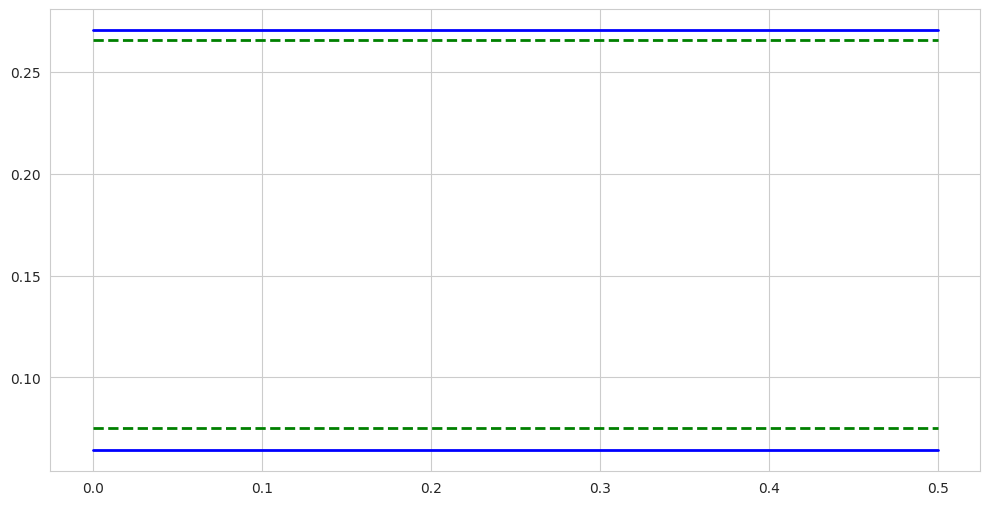

In [283]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Параметры
n_simulations = 100  # Количество симуляций
n_portfolios_per_sim = 1000  # Портфелей на симуляцию
n_assets = 30  # Количество активов
#Параметры исторических данных
mu_hist = returns.mean().mean()  # Средняя доходность
sigma_hist = returns.std().mean()  # Среднее стандартное отклонение



# Предположим, есть данные: expected_returns, cov_matrix
# (рассчитанные из исторических данных)

# Сетка для интерполяции эффективных границ
vol_grid = np.linspace(0, 0.5, 100)  # Пример: волатильность от 0% до 50%

# Списки для хранения кривых
all_curves = []


# 1. Генерация 100 симуляций
for _ in tqdm(range(n_simulations)):
    # Генерация случайных весов (без коротких продаж)
    weights = generate_weights(n_assets=30, n_portfolios=n_portfolios_per_sim, allow_short=False)
    weights /= weights.sum(axis=1)[:, np.newaxis]

    # Расчет доходности и волатильности
    # Генерация данных методом Монте-Карло (на основе исторических параметров)
    portfolio_returns = np.random.normal(loc=mu_hist, scale=sigma_hist, size=n_portfolios_per_sim)
    portfolio_volatilities = np.sqrt(np.diag(weights @ cov_matrix @ weights.T))

    # Сортировка и построение эффективной границы
    sorted_indices = np.argsort(portfolio_volatilities)
    sorted_vols = portfolio_volatilities[sorted_indices]
    sorted_rets = portfolio_returns[sorted_indices]

    efficient_frontier = []
    max_return = -np.inf
    for vol, ret in zip(sorted_volatilities, sorted_returns):
      if ret > max_return:
        efficient_frontier.append((vol, ret))
        max_return = ret

    all_curves.append(efficient_frontier)

# Поэлементное усреднение и расчет квантилей
mean_curve = np.nanmean(all_curves, axis=1)
median_curve = np.nanmedian(all_curves, axis=1)
q10 = np.nanquantile(all_curves, 0.1, axis=0)
q90 = np.nanquantile(all_curves, 0.9, axis=0)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(vol_grid, mean_curve, lw=2, color='blue', label='Средняя кривая')
plt.plot(vol_grid, median_curve, lw=2, color='green', linestyle='--', label='Медиана')
plt.fill_between(vol_grid, q10, q90, color='gray', alpha=0.2, label='10-90% квантили')

# Добавьте здесь вашу предыдущую эффективную границу, если нужно:
# plt.plot(prev_vol_grid, prev_returns, color='red', label='Предыдущая граница')

plt.title('Усредненная эффективная граница методом Монте-Карло')
plt.xlabel('Волатильность (σ)')
plt.ylabel('Доходность (μ)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

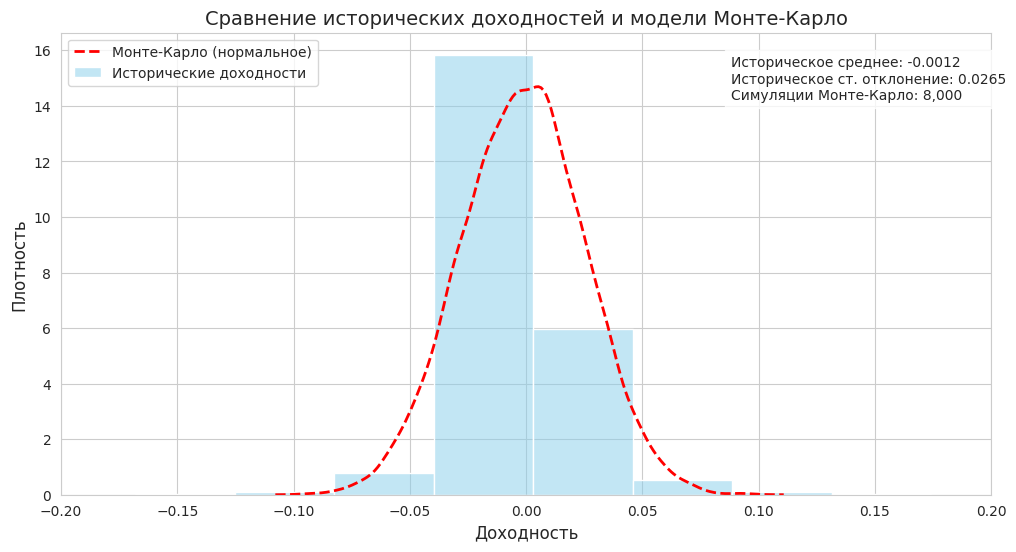

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Предположим, pivot_df — DataFrame с ценами закрытия акций
# Расчет логарифмических доходностей
returns = np.log(pivot_df / pivot_df.shift(1)).dropna()

def remove_outliers_iqr(series):
    """Удаление выбросов через межквартильный размах"""
    q25 = series.quantile(0.20)
    q75 = series.quantile(0.80)
    iqr = q75 - q25
    lower = q25 - 1.5 * iqr
    upper = q75 + 1.5 * iqr
    return series[(series >= lower) & (series <= upper)]

# Преобразуем все доходности в один вектор и удаляем выбросы
flat_returns = returns.stack().reset_index(drop=True)
filtered_returns = remove_outliers_iqr(flat_returns)

# Параметры исторических данных
mu_hist = returns.mean().mean()  # Средняя доходность
sigma_hist = returns.std().mean()  # Среднее стандартное отклонение
n_simulations = 8000  # Количество симуляций Монте-Карло

# Генерация данных методом Монте-Карло (на основе исторических параметров)
mc_returns = pd.Series(np.random.normal(loc=mu_hist, scale=sigma_hist, size=n_simulations))
#mc_returns = remove_outliers_iqr(mc_returns)

# Визуализация
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Гистограмма исторических доходностей
sns.histplot(returns.values.flatten(), bins=50, kde=False, color='skyblue',
             alpha=0.5, stat='density', label='Исторические доходности')

# KDE сгенерированных данных Монте-Карло
sns.kdeplot(mc_returns, color='red', linestyle='--', linewidth=2,
            label='Монте-Карло (нормальное)')

# Настройки графика
plt.title('Сравнение исторических доходностей и модели Монте-Карло', fontsize=14)
plt.xlabel('Доходность', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.xlim(left=-0.2, right=0.2)
plt.legend()

# Вывод статистик
stats_text = (
    f'Историческое среднее: {mu_hist:.4f}\n'
    f'Историческое ст. отклонение: {sigma_hist:.4f}\n'
    f'Симуляции Монте-Карло: {n_simulations:,}'
)
plt.text(0.72, 0.95, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

100%|██████████| 100/100 [00:03<00:00, 31.97it/s]
<ipython-input-290-5b413c1ddc38>:56: RuntimeWarning: Mean of empty slice
  mean_curve = np.nanmean(all_curves, axis=0)


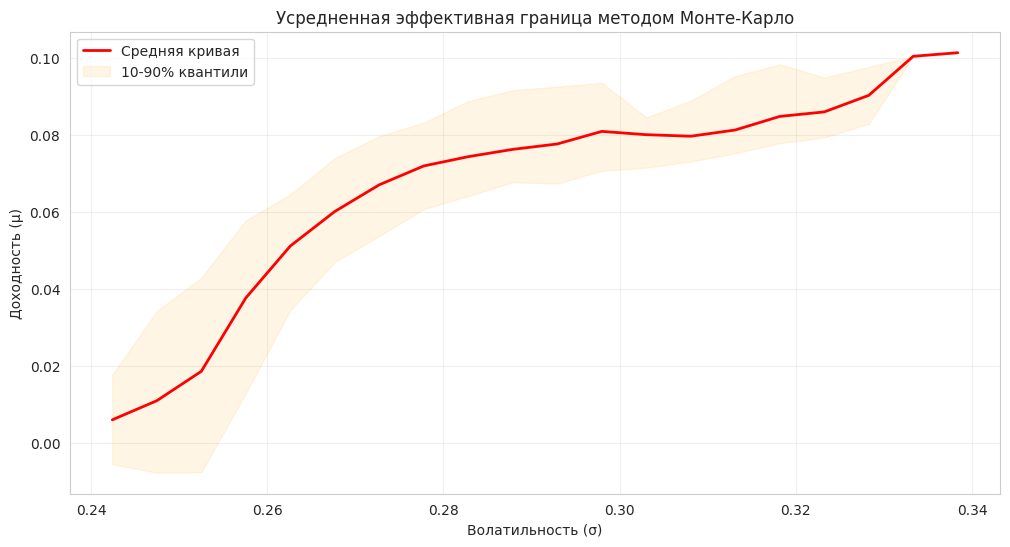

In [290]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def generate_weights(n_assets, n_portfolios, allow_short=False):
    """Генерация случайных весов портфелей."""
    if allow_short:
        weights = np.random.randn(n_portfolios, n_assets)
    else:
        weights = np.random.rand(n_portfolios, n_assets)
    weights /= weights.sum(axis=1)[:, np.newaxis]
    return weights

# Параметры
n_simulations = 100
n_portfolios_per_sim = 1000
n_assets = 30

#Параметры исторических данных
mu_hist = returns.mean().mean()  # Средняя доходность
sigma_hist = returns.std().mean()  # Среднее стандартное отклонение

# Сетка для интерполяции
vol_grid = np.linspace(0, 0.5, 100)
all_curves = []

# Симуляция
for _ in tqdm(range(n_simulations)):
    # Генерация случайных весов (без коротких продаж)
    weights = generate_weights(n_assets, n_portfolios_per_sim, allow_short=False)

    # Генерация данных методом Монте-Карло (на основе исторических параметров)
    portfolio_returns = np.random.normal(loc=mu_hist, scale=sigma_hist, size=n_portfolios_per_sim)
    portfolio_volatilities = np.sqrt(np.diag(weights @ cov_matrix @ weights.T))

    # Сортировка и построение эффективной границы
    sorted_indices = np.argsort(portfolio_volatilities)
    sorted_vols = portfolio_volatilities[sorted_indices]
    sorted_rets = portfolio_returns[sorted_indices]

    efficient_frontier = []
    max_ret = -np.inf
    for vol, ret in zip(sorted_vols, sorted_rets):
        if ret > max_ret:
            efficient_frontier.append((vol, ret))
            max_ret = ret

    # Интерполяция на общую сетку
    if len(efficient_frontier) > 1:
        vols, rets = zip(*efficient_frontier)
        interp_rets = np.interp(vol_grid, vols, rets, left=np.nan, right=np.nan)
        all_curves.append(interp_rets)

# Усреднение
all_curves = np.array(all_curves)
mean_curve = np.nanmean(all_curves, axis=0)
q10 = np.nanquantile(all_curves, 0.1, axis=0)
q90 = np.nanquantile(all_curves, 0.9, axis=0)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(vol_grid, mean_curve, 'r', lw=2, label='Средняя кривая')
plt.fill_between(vol_grid, q10, q90, color='orange', alpha=0.1, label='10-90% квантили')
plt.title('Усредненная эффективная граница методом Монте-Карло')
plt.xlabel('Волатильность (σ)')
plt.ylabel('Доходность (μ)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()